**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration
from covid19model.models.utils import draw_sample_COVID19_SEIRD


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [ ]:
# import dask

# from dask.distributed import Client, progress
# client = Client(threads_per_worker=16, n_workers=1)
# client

# Get public data

In [ ]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)


In [2]:
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Luik_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Liège']

In [3]:
#Luik_hosp_data.plot('DATE','NEW_IN')

In [4]:
Luik_ts = Luik_hosp_data[['DATE','NEW_IN']].set_index('DATE')

In [ ]:
fig,ax = plt.subplots()
Luik_ts.reset_index() .plot('DATE','NEW_IN', ax=ax)
ax.set_xlim('2020-09-01', '2020-11-01')

# Load data

In [5]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
#province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[60000].iloc[:9]))

# Initialize the model

In [6]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [7]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [8]:
fig_path = '../results/calibrations_provinces/'
samples_path = '../data/interim/model_parameters/provinces/'

# Calibration on first wave

In [9]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-25'#'2020-03-22'
end_ramp = '2020-05-23'

In [10]:
len(Luik_ts.loc[start_date:end_beta])

11

In [11]:
len(Luik_ts.loc[end_beta:end_ramp])

60

In [12]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave1_1000steps'
# maxiter=100
# popsize=200
# steps_mcmc=10000


In [14]:
samples_dict = full_calibration(model, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                            fig_path=fig_path, samples_path=samples_path,
                            maxiter=100, popsize=100, steps_mcmc=1000)



No constraints given.
New best for swarm at iteration 1: [14.15919088 32.15314527  0.04306642] 31.362773574772
Best after iteration 1: [14.15919088 32.15314527  0.04306642] 31.362773574772
Best after iteration 2: [14.15919088 32.15314527  0.04306642] 31.362773574772
Best after iteration 3: [14.15919088 32.15314527  0.04306642] 31.362773574772
Best after iteration 4: [14.15919088 32.15314527  0.04306642] 31.362773574772
Best after iteration 5: [14.15919088 32.15314527  0.04306642] 31.362773574772
New best for swarm at iteration 6: [ 7.47593173 33.98411243  0.04125622] 29.428186130358103
Best after iteration 6: [ 7.47593173 33.98411243  0.04125622] 29.428186130358103
Best after iteration 7: [ 7.47593173 33.98411243  0.04125622] 29.428186130358103
Best after iteration 8: [ 7.47593173 33.98411243  0.04125622] 29.428186130358103
New best for swarm at iteration 9: [ 9.66588357 34.75533614  0.04047664] 29.342944035540626
Best after iteration 9: [ 9.66588357 34.75533614  0.04047664] 29.3429440

Best after iteration 79: [ 8.49793416 36.07912401  0.03931421] 29.038012135287257
Best after iteration 80: [ 8.49793416 36.07912401  0.03931421] 29.038012135287257
New best for swarm at iteration 81: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 81: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 82: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 83: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 84: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 85: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 86: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 87: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
Best after iteration 88: [ 8.49794247 36.06348878  0.03931425] 29.0380121314463
New best for swarm at iteration 89: [ 8.49792018 36.07383786  0.03931426] 29.038012131302164
Stopping sea

100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s]


Calibrating compliance ramp. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!


<IPython.core.display.Javascript object>


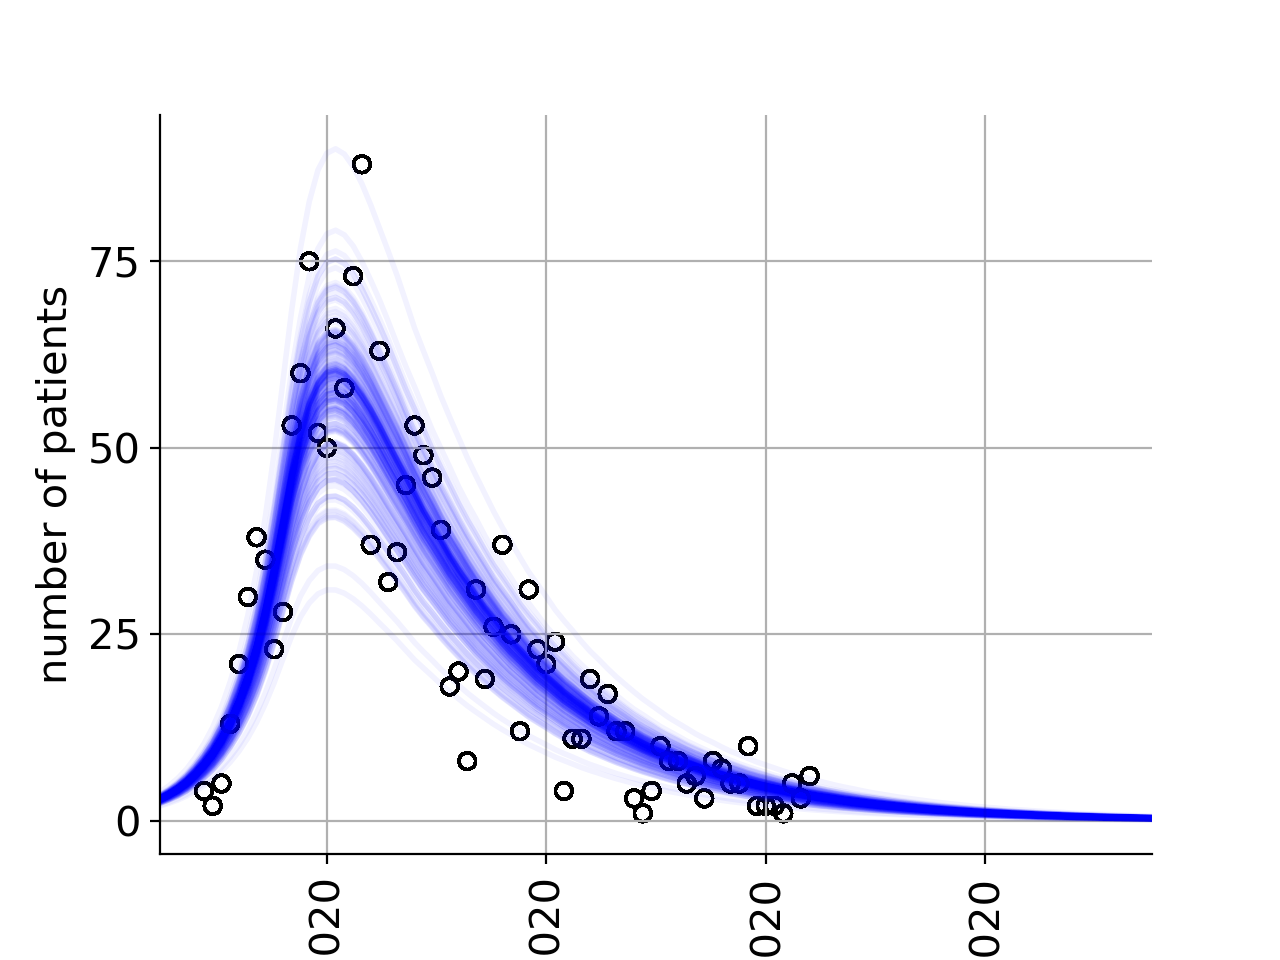

In [18]:
states = [['H_in']]
end_date = '2020-07-01'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
#     idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#     model.parameters['tau'] = samples_dict['tau'][idx]
#     prevention = samples_dict['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict['lag_time'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', '2020-07-01')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Run simulation until first september

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_60d_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
out_sept = model.sim(time='2020-09-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=50, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)


In [ ]:
states = out_sept.isel(time=-1).mean(dim="draws")

In [ ]:
initial_states_sept = {key:states[key].values for key in initial_states.keys()}
    

# Calibration on second wave

In [ ]:
# Second wave
start_date = '2020-09-01'
end_beta = '2020-10-25'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model_sept = models.COVID19_SEIRD(initial_states_sept, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave2_1000steps'
# maxiter=100
# popsize=200
# steps_mcmc=10000


In [ ]:
samples_dict = full_calibration(model_sept, timeseries, spatial_unit, start_date, end_beta, end_ramp=None, 
                            fig_path=fig_path, samples_path=samples_path,
                            maxiter=100, popsize=100, steps_mcmc=1000)



In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
#     idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#     model.parameters['tau'] = samples_dict['tau'][idx]
#     prevention = samples_dict['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict['lag_time'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-09-01', '2021-01-01')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Check step-by-step for debugging if needed

In [ ]:
# define dataset
data=Luik_ts['NEW_IN']
states = [["H_in"]]

In [ ]:

#############################################
####### CALIBRATING BETA AND LAG_TIME #######
#############################################

# set optimisation settings
parNames_pso = ['sigma_data','extraTime','beta'] # must be a list!
bounds_pso=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run pso optimisation
theta = MCMC.fit_pso(model,data,parNames_pso,states,bounds_pso,maxiter=maxiter,popsize=popsize)

lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))

model.parameters.update({'beta': theta[2]})

parNames_mcmc = ['sigma_data','beta'] # must be a list!
bounds_mcmc=((1,200),(0.01,0.10))

In [ ]:


# run MCMC calibration
pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model, bounds_mcmc, data, states, parNames_mcmc))
sampler.run_mcmc(pos, steps_mcmc, progress=True);

samples_beta = sampler.get_chain(discard=500,flat=False)
flat_samples_beta = sampler.get_chain(discard=500,flat=True)

try:
    sampler.get_autocorr_time()
except:
    print('Calibrating beta. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!')


traceplot(samples_beta,labels=['$\sigma_{data}$','$\\beta$'],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})
plt.savefig(fig_path+'traceplots/beta_'+str(spatial_unit)+'_'+str(datetime.date.today())+'.pdf',
            dpi=600, bbox_inches='tight')

fig = corner.corner(flat_samples_beta,labels=['$\sigma_{data}$','$\\beta$'])
fig.set_size_inches(8, 8)
plt.savefig(fig_path+'cornerplots/beta_'+str(spatial_unit)+'_'+str(datetime.date.today())+'.pdf',
            dpi=600, bbox_inches='tight')

In [ ]:
#############################################
####### CALIBRATING COMPLIANCE PARAMS #######
#############################################

samples_beta = {'beta': flat_samples_beta[:,1].tolist()}

# Create checkpoints dictionary
chk_beta_pso = {
    'time':  [lag_time],
    'Nc':    [0.2*Nc_home + 0.3*Nc_work + 0.2*Nc_transport],
}
# define dataset
data=[timeseries[start_date:end_ramp]]
# set optimisation settings
parNames_pso2 = ['sigma_data','l','tau','prevention'] # must be a list!
bounds_pso2=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model, data, parNames_pso2, states, bounds_pso2,
                     checkpoints=chk_beta_pso, samples=samples_beta, maxiter=maxiter,popsize=popsize)

model.parameters.update({'l': theta[1], 'tau': theta[2]})
prevention = theta[2]

# Create checkpoints dictionary
chk_beta_MCMC = {
    'time':  [lag_time],
    'Nc':    [prevention*(1.0*Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure)]}


bounds_mcmc2=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds_mcmc2,data,states,parNames_pso2,chk_beta_MCMC,samples_beta))

sampler.run_mcmc(pos, steps_mcmc, progress=True);

try:
    sampler.get_autocorr_time()
except:
    print('Calibrating compliance ramp. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!')


samples_ramp = sampler.get_chain(discard=200,flat=False)
flat_samples_ramp = sampler.get_chain(discard=200,flat=True)

traceplot(samples_ramp, labels=["$\sigma_{data}$","l","$\\tau$","prevention"],
          plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})
plt.savefig(fig_path+'traceplots/ramp_'+str(spatial_unit)+'_'+str(datetime.date.today())+'.pdf',
            dpi=600, bbox_inches='tight')

fig = corner.corner(flat_samples_ramp, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"])
fig.set_size_inches(9, 9)
plt.savefig(fig_path+'cornerplots/ramp_'+str(spatial_unit)+'_'+str(datetime.date.today())+'.pdf',
            dpi=600, bbox_inches='tight')

#############################################
####### CALCULATING R0 ######################
#############################################

R0 =[]
for i in range(len(samples_beta['beta'])):
    R0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_beta['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))
R0_stratified = np.zeros([initN.size,len(samples_beta['beta'])])
for i in range(len(samples_beta['beta'])):
    R0_stratified[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_beta['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
R0_stratified_dict = pd.DataFrame(R0_stratified).T.to_dict(orient='list')

samples_dict={'calibration_data':states[0][0], 'start_date':start_date,
              'end_beta':end_beta, 'end_ramp':end_ramp,
              'maxiter': maxiter, 'popsize':popsize, 'steps_mcmc':steps_mcmc,
              'R0':R0, 'R0_stratified_dict':R0_stratified_dict,
              'lag_time': lag_time, 'beta': samples_beta['beta'],
              'l': flat_samples_ramp[:,1].tolist(),'tau':flat_samples_ramp[:,2].tolist(),
              'prevention':flat_samples_ramp[:,3].tolist()}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'.json', 'w') as fp:
    json.dump(samples_dict, fp)



# Run in parallel

In [ ]:
arr_list = list(nonpublic_ts.NIS.unique())

In [ ]:
def run_me_parallel(arr):
    arrond_ts = nonpublic_ts.pivot(index='DATE', columns='NIS', values='hospitalised_IN')[arr]
    samples_dict = full_calibration(model, arrond_ts, arr, start_date, end_beta, end_ramp, 
                                fig_path, samples_path)
                                #maxiter=10, popsize=10, steps_mcmc=250)
    
    states = [['H_in']]
    end_date = '2020-09-20'
    data=[arrond_ts[start_date:end_ramp].values]
    fig,ax=plt.subplots()
    for i in range(200):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
        model.parameters['tau'] = samples_dict['tau'][idx]
        prevention = samples_dict['prevention'][idx]
        # Create a dictionary of past policies
        chk = {'time':   [start_date], 
              'Nc':      [prevention*(Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure)]
              }
        y_model = model.sim(time=end_date, excess_time=samples_dict['lag_time'],checkpoints=chk)
        ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

    data_after_calib = arrond_ts[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim('2020-03-10', '2020-08-03')
    fig.savefig('../results/calibrations_arrondissements/'+str(arr)+'_'+str(datetime.date.today())+'.pdf',
                bbox_inches='tight', dpi=600)
    return

In [ ]:
tasks = []
for arr in arr_list:
    task = dask.delayed(run_me_parallel)(arr)
    tasks.append(task)
    

In [ ]:
dask.compute(*tasks, scheduler='processes')

In [ ]:
run_date = '2020-08-22'

In [ ]:
with open(samples_path+'44000'+'_'+run_date+'.json', 'r') as fp:
    samples_dict = json.load(fp)